In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

In [4]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

<Figure size 864x720 with 0 Axes>

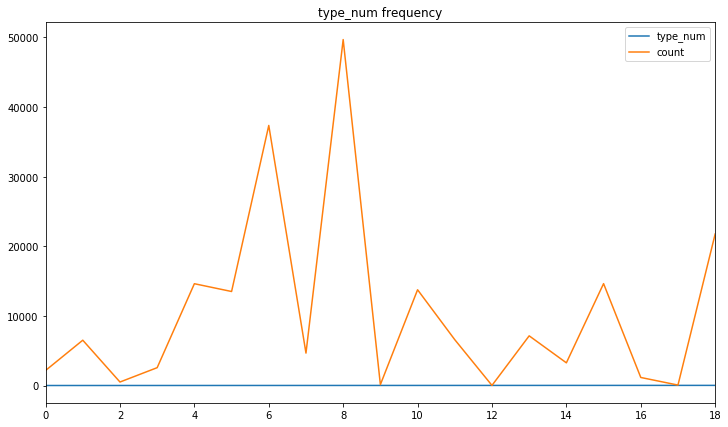

In [5]:
grouped_type_num = train.groupby("type_num", sort='count').size().reset_index(name='count')
fig = plt.figure(figsize=(12,10))
grouped_type_num.plot(figsize=(12,7), title="type_num frequency")

In [6]:
train_x = train.drop(columns=['type', 'type_num'], axis=1)
train_y = train['type_num']
test_x = test

In [7]:
print(train_x.isnull().any().sum())
print(train_y.isnull().any().sum())
print(test_x.isnull().any().sum())

0
0
0


In [8]:
train_x.columns

Index(['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z'],
      dtype='object')

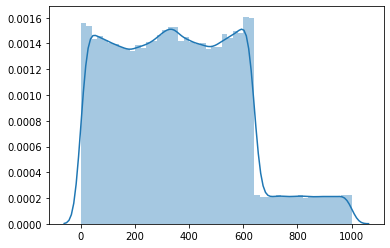

In [9]:
# distribution of Amount
amount = [train_x['fiberID'].values]
sns.distplot(amount)

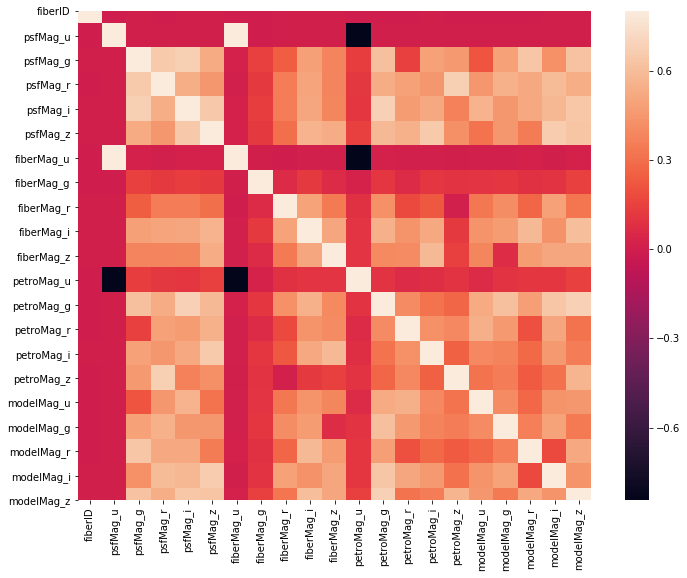

In [10]:
# heat map of correlation of features
correlation_matrix = train_x.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [11]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train_x.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, train_y], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,type_num
0,-32.078987,4.126174,9.034291,8
1,-30.247245,3.279877,7.434948,8
2,-25.813486,-2.756650,-4.727174,8
3,-29.419875,2.172165,5.053226,8
4,-36.001919,6.099129,10.687131,10


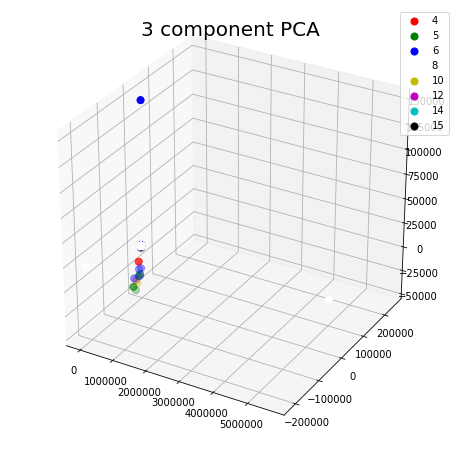

In [12]:
# 2D visualization
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1) 
ax = fig.gca(projection='3d')
ax.set_title('3 component PCA', fontsize = 20)
targets = [4,5,6,8,10,12,14,15,22]
colors = ['r', 'g','b','w','y','m','c','k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['type_num'] == target
    ax.scatter3D(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

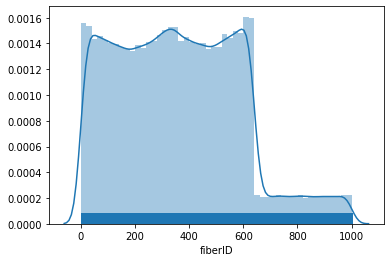

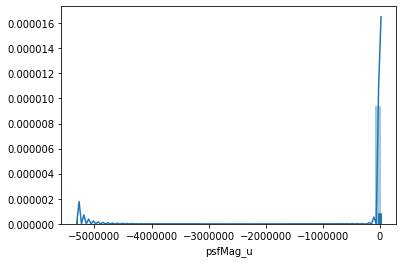

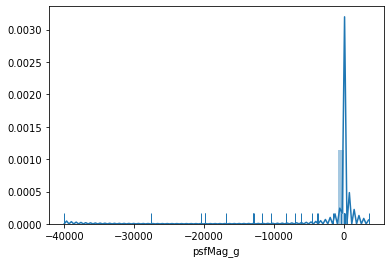

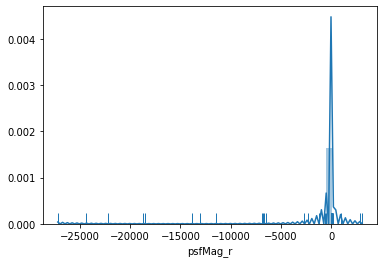

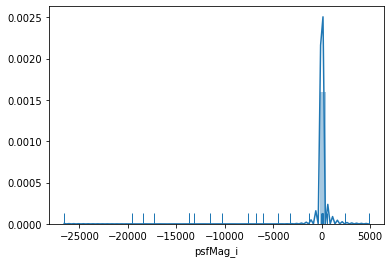

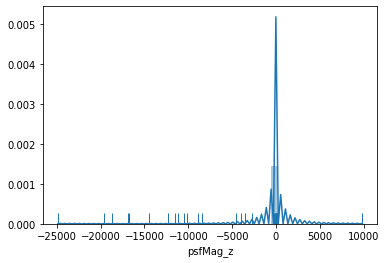

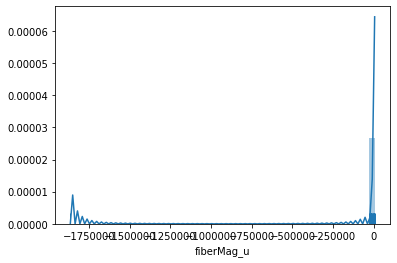

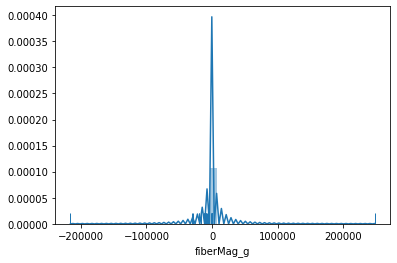

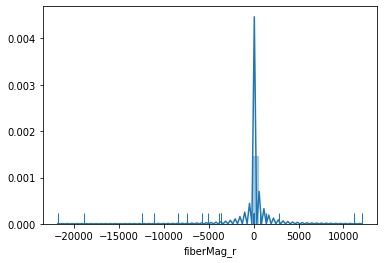

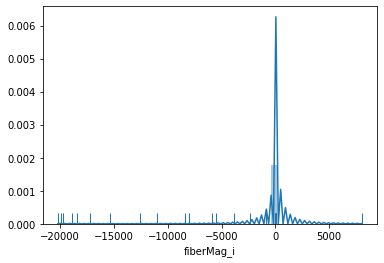

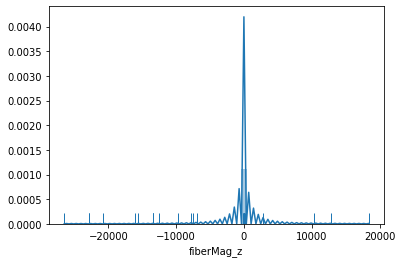

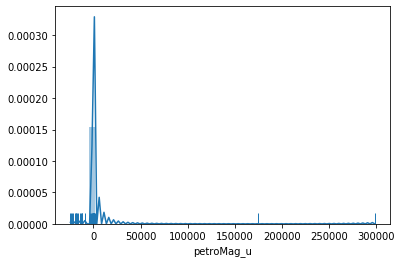

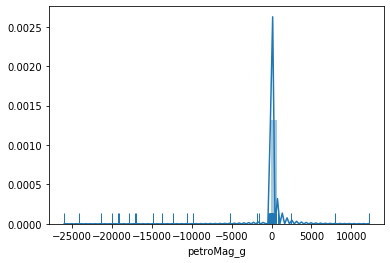

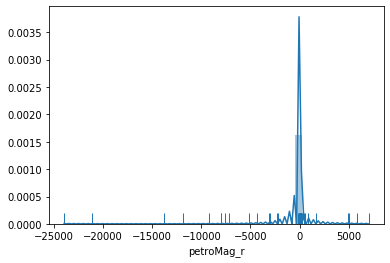

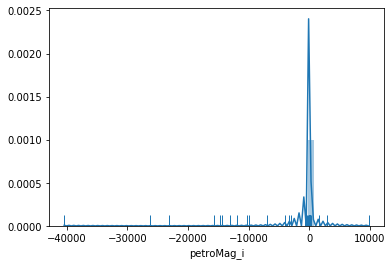

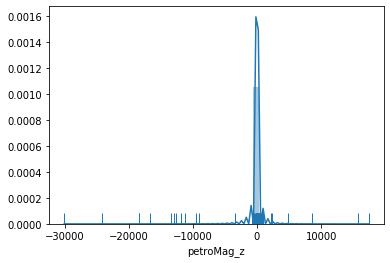

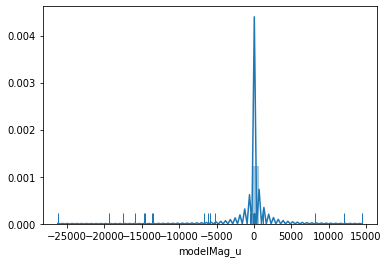

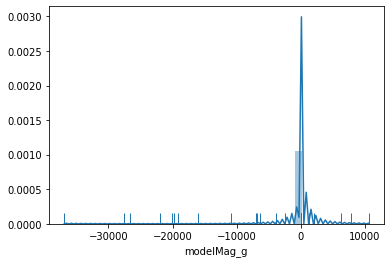

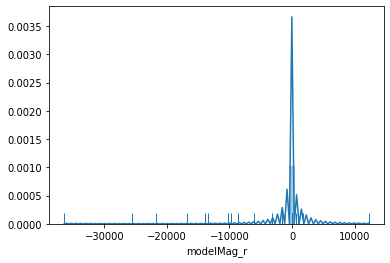

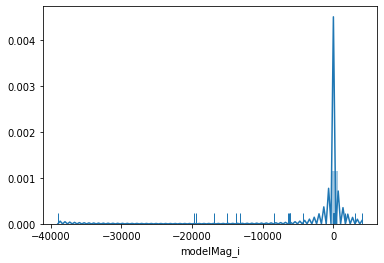

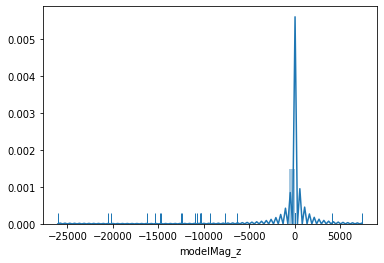

In [13]:
for col in train_x.columns:
    sns.distplot(train_x[col], kde=True, rug=True)
    plt.show()
#sns.distplot(train_x["psfMag_u"], kde=True, rug=True)
#plt.legend(title="Columns")


In [14]:
train_x["psfMag_u"].min()

-5310801.77091916

In [15]:
robust_train_x = RobustScaler().fit_transform(train_x)

In [16]:
df_robust_train_x = pd.DataFrame(robust_train_x,columns=train_x.columns)

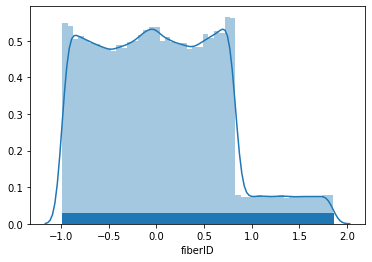

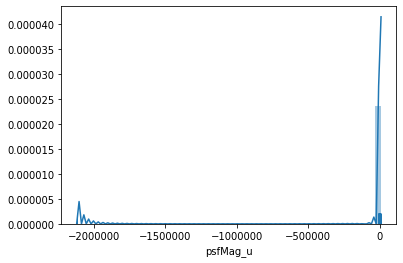

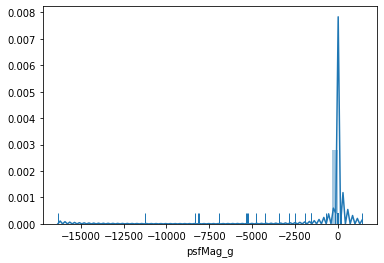

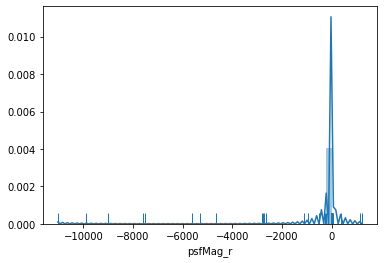

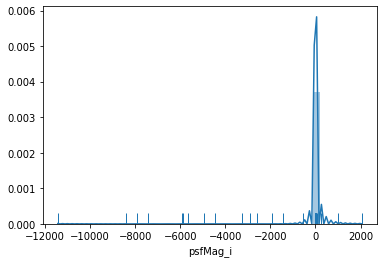

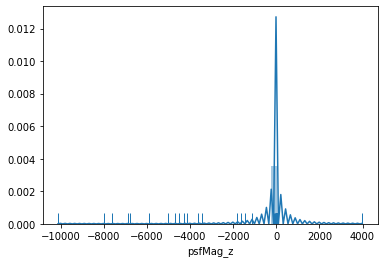

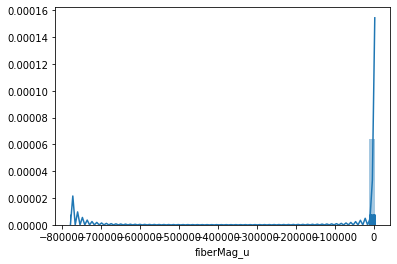

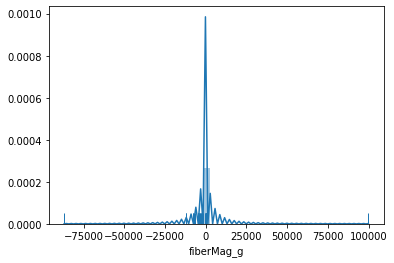

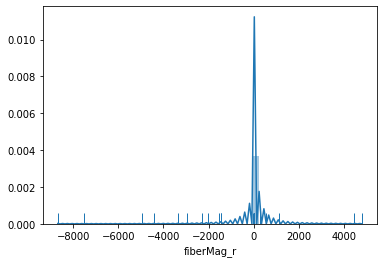

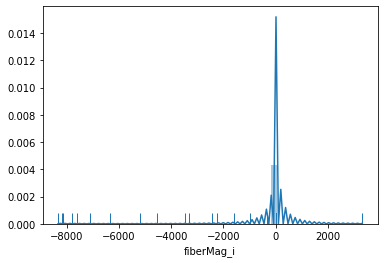

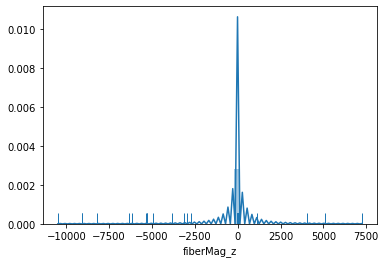

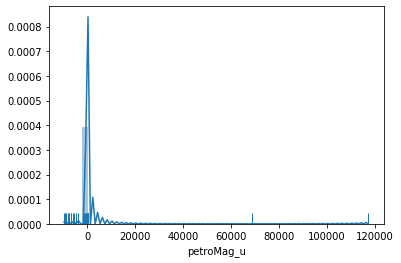

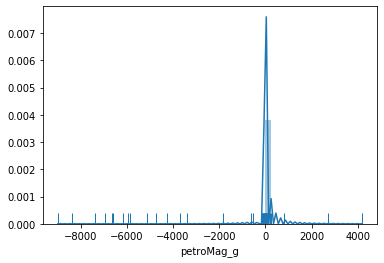

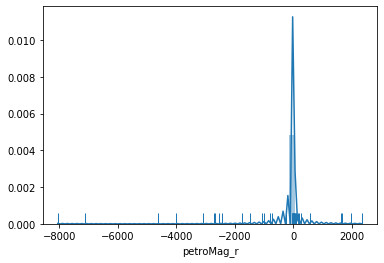

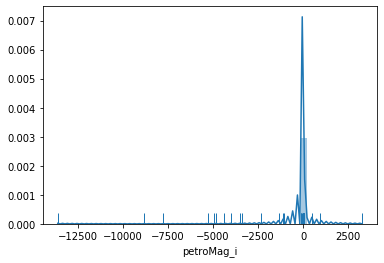

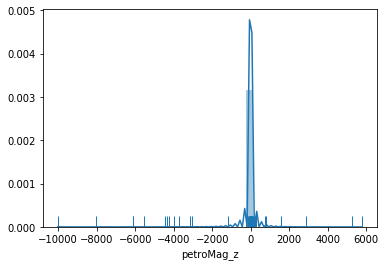

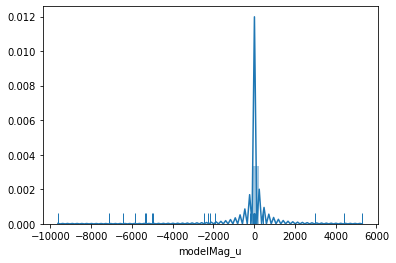

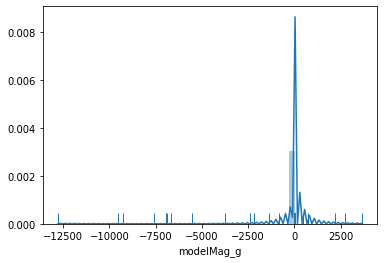

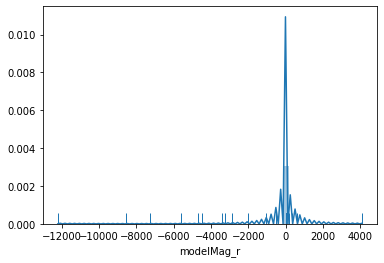

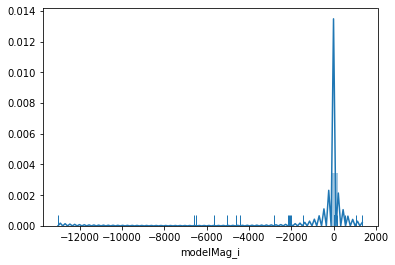

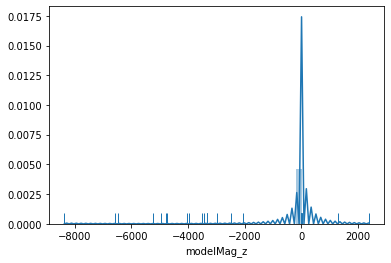

In [17]:
for col in df_robust_train_x.columns:
    sns.distplot(df_robust_train_x[col], kde=True, rug=True)
    plt.show()

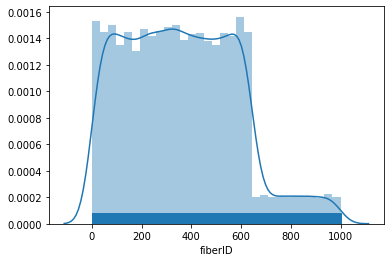

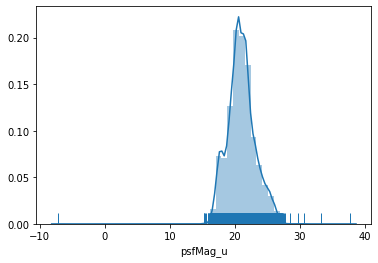

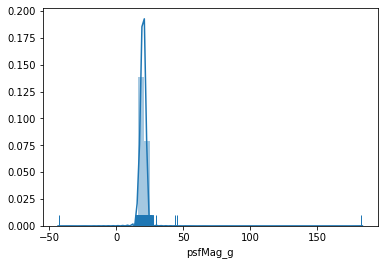

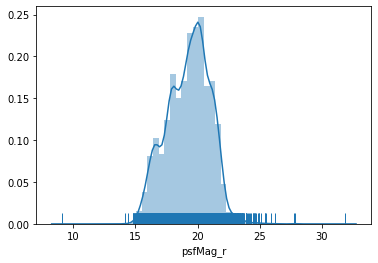

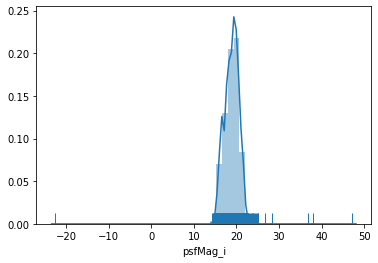

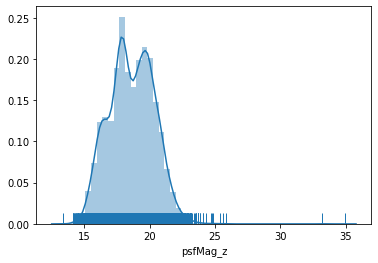

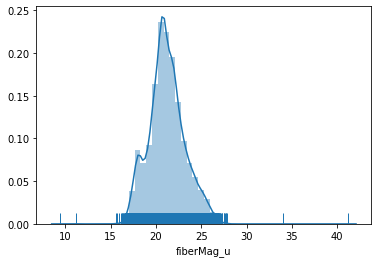

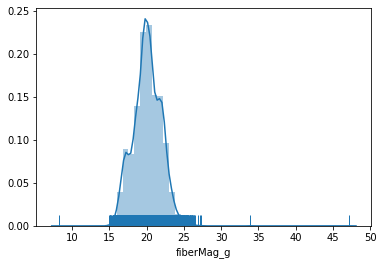

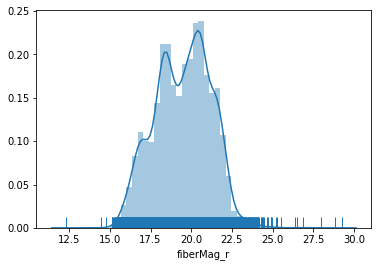

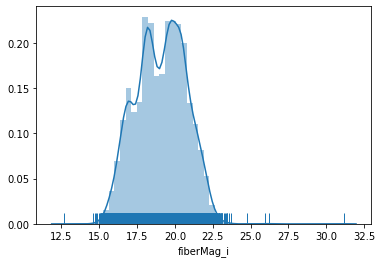

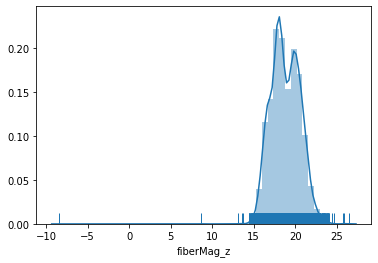

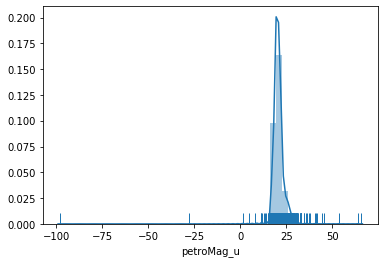

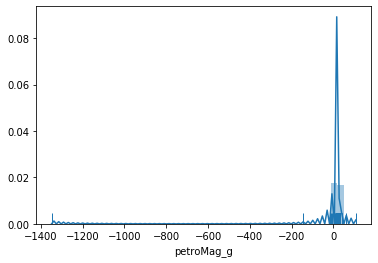

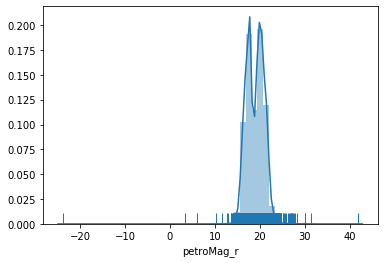

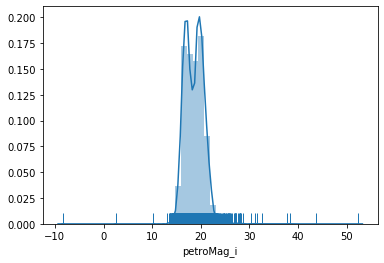

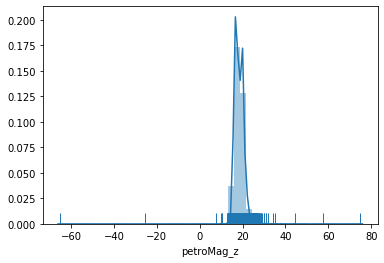

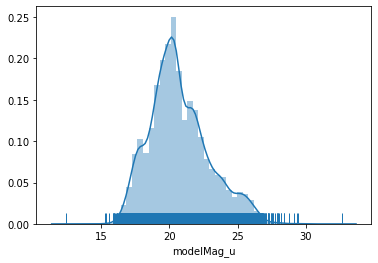

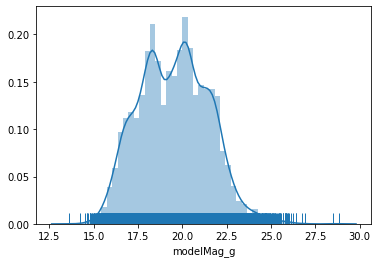

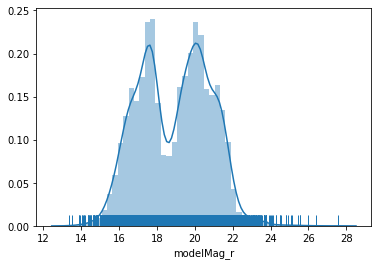

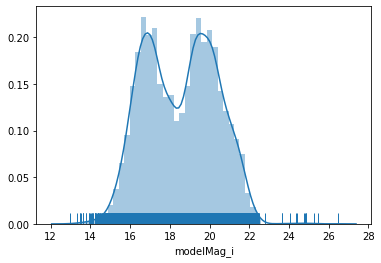

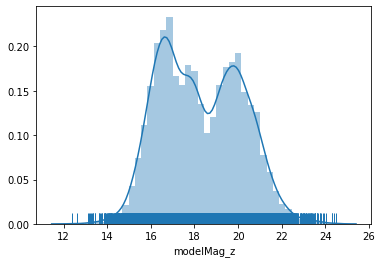

In [18]:
for col in test.columns:
    sns.distplot(test[col], kde=True, rug=True)
    plt.show()

In [19]:
robust_test_x = RobustScaler().fit_transform(test_x)

In [20]:
df_robust_test_x = pd.DataFrame(robust_test_x,columns=test_x.columns)

In [21]:
#로버스트 정규화 데이터
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest.fit(df_robust_train_x, train_y)
y_pred = forest.predict_proba(df_robust_test_x)
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission.csv', index=True)